In [1]:
%matplotlib inline

This example loops through all insitu stations that measure soil moisture with a depth between 0 and 0.1m
it then finds the nearest ASCAT grid point and reads the ASCAT data. After temporal matching and scaling using linear
CDF matching it computes several metrics, like the correlation coefficients(Pearson's, Spearman's and Kendall's), Bias,
RMSD as well as the Nash–Sutcliffe model efficiency coefficient.

First, we prepare the readers for the ASCAT and ISMN data:

In [2]:
import pytesmo.io.ismn.interface as ismn
import ascat
import pytesmo.temporal_matching as temp_match
import pytesmo.scaling as scaling
import pytesmo.df_metrics as df_metrics
import pytesmo.metrics as metrics

import os
import matplotlib.pyplot as plt

testdata_folder = '/pytesmo/testdata'

ascat_data_folder = os.path.join(testdata_folder,
                                 'sat/ascat/netcdf/55R22')
ascat_grid_folder = os.path.join(testdata_folder,
                                 'sat/ascat/netcdf/grid')
static_layers_folder = os.path.join(testdata_folder,
                                    'sat/h_saf/static_layer')

# init the ASCAT SSM reader with the paths
ascat_SSM_reader = ascat.AscatSsmCdr(ascat_data_folder, ascat_grid_folder,
                                     grid_filename='TUW_WARP5_grid_info_2_1.nc',
                                     static_layer_path=static_layers_folder)
ascat_SSM_reader.read_bulk = True


# set path to ISMN data
ismn_data_folder = os.path.join(testdata_folder,
                                 'ismn/multinetwork/header_values')

# Initialize reader
ISMN_reader = ismn.ISMN_Interface(ismn_data_folder)

/space/tools/miniconda3/envs/pytesmo/lib/python2.7/site-packages/ascat/timeseries.py:128: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  land_gp = np.where(grid_nc.variables['land_flag'][:] == 1)[0]


Then, we loop through the ISMN stations and timeseries, find the corresponding ASCAT gridpoint and compare them, producing three graphs per reference timeseries. The first graph contains temporally matched but unscaled data; the second graph has the data scaled to the in-situ scale with linear interpolation cumulative density function matching; the third graph is a scatter plot of the scaled data. After that, metrics are calculated and printed. Only the first two stations are plotted to limit the runtime.

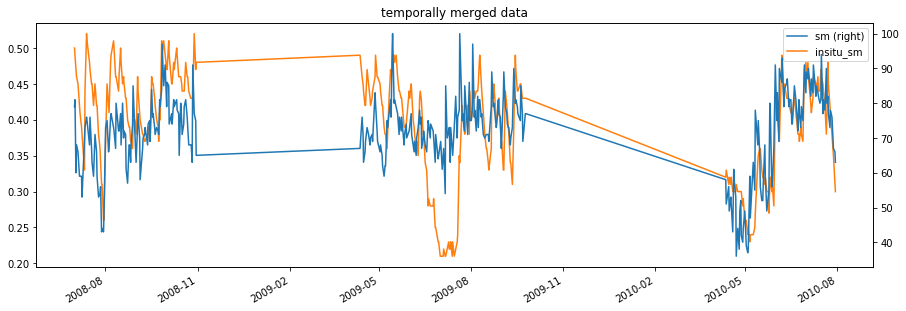

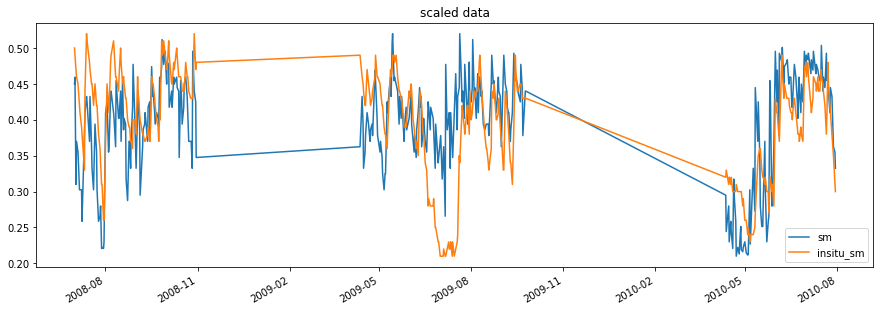

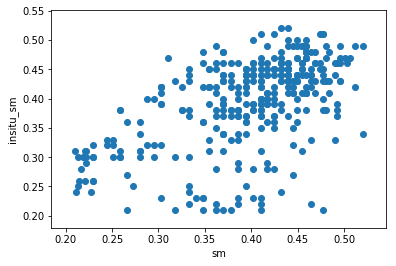

ISMN time series: MAQU CST_01 0.05 m - 0.05 m soil moisture measured with ECH20-EC-TM 
compared to
GPI: 1814367 Lon: 102.142 Lat: 33.877
Results:
(Pearsons_r(sm_and_insitu_sm=0.5478988704236728), p_value(sm_and_insitu_sm=2.3369770597942426e-29))
Spearman's (rho,p_value) SpearmanrResult(correlation=0.5393457276100486, pvalue=2.471651148163483e-28)
Kendalls's (tau,p_value) KendalltauResult(correlation=0.39071239814353836, pvalue=2.102043412900702e-26)
(Kendall_tau(sm_and_insitu_sm=0.39071239814353836), p_value(sm_and_insitu_sm=2.102043412900702e-26))
rmsd(sm_and_insitu_sm=0.06992865588188281)
Bias 0.001813130846744282
Nash Sutcliffe 0.042004712074436124


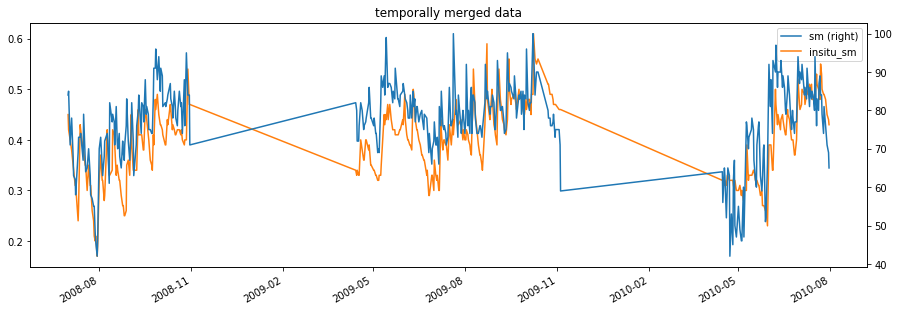

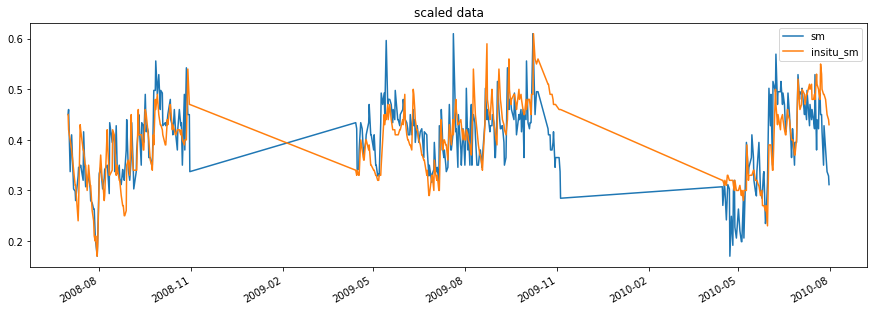

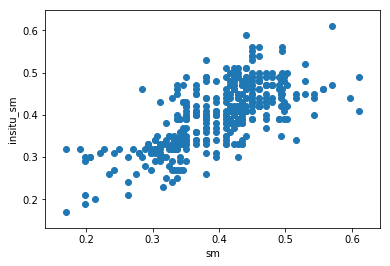

ISMN time series: MAQU CST_02 0.05 m - 0.05 m soil moisture measured with ECH20-EC-TM 
compared to
GPI: 1803695 Lon: 102.145 Lat: 33.652
Results:
(Pearsons_r(sm_and_insitu_sm=0.698429670063646), p_value(sm_and_insitu_sm=1.8519622022307244e-57))
Spearman's (rho,p_value) SpearmanrResult(correlation=0.7002289363385688, pvalue=7.210488519937935e-58)
Kendalls's (tau,p_value) KendalltauResult(correlation=0.526843974043335, pvalue=3.6191991004848767e-50)
(Kendall_tau(sm_and_insitu_sm=0.526843974043335), p_value(sm_and_insitu_sm=3.6191991004848767e-50))
rmsd(sm_and_insitu_sm=0.05816297399771903)
Bias -0.0016970872025742767
Nash Sutcliffe 0.4079498493560706


In [3]:
i = 0

label_ascat = 'sm'
label_insitu = 'insitu_sm'

# this loops through all stations that measure soil moisture
for station in ISMN_reader.stations_that_measure('soil moisture'):
    
    # this loops through all time series of this station that measure soil moisture
    # between 0 and 0.1 meters
    for ISMN_time_series in station.data_for_variable('soil moisture', min_depth=0, max_depth=0.1):

        ascat_time_series = ascat_SSM_reader.read(ISMN_time_series.longitude,
                                                  ISMN_time_series.latitude,
                                                  mask_ssf=True,
                                                  mask_frozen_prob=80,
                                                  mask_snow_prob=80)

        # focus only on the relevant variable
        ascat_time_series.data = ascat_time_series.data[label_ascat]

        # drop nan values before doing any matching
        ascat_time_series.data = ascat_time_series.data.dropna()

        ISMN_time_series.data = ISMN_time_series.data.dropna()
        
        # rename the soil moisture column in ISMN_time_series.data to insitu_sm
        # to clearly differentiate the time series when they are plotted together
        ISMN_time_series.data.rename(columns={'soil moisture':label_insitu}, inplace=True)
        
        # get ISMN data that was observerd within +- 1 hour(1/24. day) of the ASCAT observation
        # do not include those indexes where no observation was found
        matched_data = temp_match.matching(ascat_time_series.data, ISMN_time_series.data,
                                                window=1 / 24.)
        # matched ISMN data is now a dataframe with the same datetime index
        # as ascat_time_series.data and the nearest insitu observation      
        
        # continue only with relevant columns
        matched_data = matched_data[[label_ascat, label_insitu]]
        
        # the plot shows that ISMN and ASCAT are observed in different units
        matched_data.plot(figsize=(15, 5), secondary_y=[label_ascat],
                          title='temporally merged data')
        plt.show()
        
        # this takes the matched_data DataFrame and scales all columns to the 
        # column with the given reference_index, in this case in situ 
        scaled_data = scaling.scale(matched_data, method='lin_cdf_match',
                                         reference_index=1)
        
        # now the scaled ascat data and insitu_sm are in the same space    
        scaled_data.plot(figsize=(15, 5), title='scaled data')
        plt.show()
        
        plt.scatter(scaled_data[label_ascat].values, scaled_data[label_insitu].values)
        plt.xlabel(label_ascat)
        plt.ylabel(label_insitu)
        plt.show()
        
        # calculate correlation coefficients, RMSD, bias, Nash Sutcliffe
        x, y = scaled_data[label_ascat].values, scaled_data[label_insitu].values
        
        print "ISMN time series:", ISMN_time_series
        print "compared to"
        print ascat_time_series
        print "Results:"
        
        # df_metrics takes a DataFrame as input and automatically
        # calculates the metric on all combinations of columns
        # returns a named tuple for easy printing
        print df_metrics.pearsonr(scaled_data)
        print "Spearman's (rho,p_value)", metrics.spearmanr(x, y)
        print "Kendalls's (tau,p_value)", metrics.kendalltau(x, y)
        print df_metrics.kendalltau(scaled_data)
        print df_metrics.rmsd(scaled_data)
        print "Bias", metrics.bias(x, y)
        print "Nash Sutcliffe", metrics.nash_sutcliffe(x, y)
        
        
    i += 1

    # only show the first 2 stations, otherwise this program would run a long time
    # and produce a lot of plots
    if i >= 2:
        break